## procedure to load the data from the json format to rating matrix

In [1]:
from collections import defaultdict
import os
import struct
import numpy as np
import random

# load data from amazon reviews dataset csv
def load_data_hybrid(data_path, min_items=1, min_users=1, sampling= True, sample_size = 0.5):
    user_ratings = defaultdict(set)
    item_ratings = defaultdict(set)
    max_u_id = -1
    max_i_id = -1
    user_count = 0
    item_count = 0
    reviews = 0
    users = {}  # aid to id LUT
    items = {}  # asid to id LUT
    brands = {}
    prices = {}
    prod_desc = {}
    random.seed(0)
    with open(data_path, 'r') as f:
        for line in f.readlines()[1:]:
            if (sampling and random.random()>sample_size):
                continue
            reviews += 1
            if (len(line.split(","))==6):
                auid, asid, _, brand, price, product_desc = line.split(",")
            else:
                auid, asid, _, brand, price = line.split(",")

            u, i = None, None

            if auid in users:
                u = users[auid]
            else:
                user_count += 1  # new user so increment
                users[auid] = user_count
                u = user_count

            if asid in items:
                i = items[asid]
            else:
                item_count += 1  # new i so increment
                items[asid] = item_count
                i = item_count
                brands[i] = brand
                if (price=='' or price=='\r\n' or price=='\n'):
                    prices[i] = 0
                else:
                    prices[i] = float(price.rstrip())
                if (len(line.split(",")) == 6):
                    prod_desc[i] = [int(el) for el in list(product_desc)[:-2][1:]]
                    if (len(prod_desc[i])==0):
                        prod_desc[i] = list(np.zeros(4525))

            user_ratings[u].add(i)
            item_ratings[i].add(u)
            max_u_id = max(u, max_u_id)
            max_i_id = max(i, max_i_id)

    print "max_u_id: ", max_u_id
    print "max_i_id: ", max_i_id
    print "reviews : ", reviews

    # filter out users w/ less than X reviews
    num_u_id = 0
    num_i_id = 0
    num_reviews = 0
    user_ratings_filtered = defaultdict(set)
    for u, ids in user_ratings.iteritems():
        if len(ids) > min_items:
            # keep
            user_ratings_filtered[u] = ids
            num_u_id += 1
            num_reviews += len(ids)
    item_ratings_filtered = defaultdict(set)
    for ids, u in item_ratings.iteritems():
        if len(u) > min_users:
            # keep
            item_ratings_filtered[ids] = u
            num_i_id += 1


    print "u_id: ", num_u_id
    print "i_id: ", num_i_id
    print "reviews : ", num_reviews
    return max_u_id, max_i_id, users, items, user_ratings_filtered, item_ratings_filtered, brands, prices, prod_desc

## Procedure to load image features of the products

In [17]:
#load image features for the given asin collection into dictionary
def load_image_features(path, items):
    count=0
    image_features = {}
    f = open(path, 'rb')
    while True:
        asin = f.read(10)
        if asin == '': break
        features_bytes = f.read(16384) # 4 * 4096 = 16KB, fast read, don't unpack
  
        if asin in items: #only unpack 4096 bytes if w need it -- big speed up
            features = (np.fromstring(features_bytes, dtype=np.float32)/44.4722)
            iid=items[asin]
            if len(features)==0:
                image_features[iid] = np.zeros(4096)
            else:
                image_features[iid] = features
    
    return image_features

## Procedure to uniformly sample the (u,i,j) triplet from the raw data for the train set

In [3]:
import tensorflow as tf
import os
import cPickle as pickle
import numpy
import random
import matplotlib.pyplot as plt
import sys
import matplotlib.pyplot as plt
%matplotlib inline

def uniform_sample_batch(train_ratings, test_ratings, item_count, advanced_features):
    neg_items = 2
    for u in train_ratings.keys():
        t = []
        iv = []
        jv = []
        for i in train_ratings[u]:
            if (u in test_ratings.keys()):
                if (i != test_ratings[u]):  # make sure it's not in the test set
                    for k in range(1,neg_items):
                        j = random.randint(1, item_count)
                        while j in train_ratings[u]:
                            j = random.randint(1, item_count)
                        # sometimes there will not be an image for given product
                        try:
                            advanced_features[i]
                            advanced_features[j]
                        except KeyError:
                            continue
                        iv.append(advanced_features[i])
                        jv.append(advanced_features[j])
                        t.append([u, i, j])
            else:
                for k in range(1,neg_items):
                    j = random.randint(1, item_count)
                    while j in train_ratings[u]:
                        j = random.randint(1, item_count)
                    # sometimes there will not be an image for given product
                    try:
                        advanced_features[i]
                        advanced_features[j]
                    except KeyError:
                        continue
                    iv.append(advanced_features[i])
                    jv.append(advanced_features[j])
                    t.append([u, i, j])

        # block if queue is full
        if len(iv)>1:
            yield numpy.asarray(t), numpy.vstack(tuple(iv)), numpy.vstack(tuple(jv))
        else:
            continue

## Procedure to uniformly sample the (u,i,j) triplet from the raw data for the test set

In [4]:
def test_batch_generator_by_user(train_ratings, test_ratings, item_ratings, item_count, advanced_features, cold_start = False, cold_start_thresh = 5):
    # using leave one cv
    for u in random.sample(test_ratings.keys(), 4000):
    #for u in test_ratings.keys():
        i = test_ratings[u]
        if (cold_start and len(item_ratings[i]) > cold_start_thresh-1):
            continue
        t = []
        ilist = []
        jlist = []
        count = 0
        for j in random.sample(range(item_count), 100):
            # find item not in test[u] and train[u]
            if j != test_ratings[u] and not (j in train_ratings[u]):
                try:
                    advanced_features[i]
                    advanced_features[j]
                except KeyError:
                    continue

                count += 1
                t.append([u, i, j])
                ilist.append(advanced_features[i])
                jlist.append(advanced_features[j])

        # print numpy.asarray(t).shape
        # print numpy.vstack(tuple(ilist)).shape
        # print numpy.vstack(tuple(jlist)).shape
        if (len(ilist) == 0):
            #print "could not find neg item for user, count: ", count, u
            continue
        yield numpy.asarray(t), numpy.vstack(tuple(ilist)), numpy.vstack(tuple(jlist))

## Procedure to generate the (u,i) pair for the test data

In [5]:
def generate_test(user_ratings):
    '''
    for each user, random select one rating into test set
    '''
    user_test = dict()
    for u, i_list in user_ratings.items():
        user_test[u] = random.sample(user_ratings[u], 1)[0]
    return user_test

## Bayesian Personalized Ranking (BPR) Model and it's extensions (VBPR, NVBPR, Hybrid)

In [6]:
def abpr(user_count, item_count, advanced_features, bpr_extension= True, hidden_dim=10, hidden_img_dim=10,
         l2_regulization=0.1,
         bias_regulization=0.01,
         embed_regulization = 0,
         image_regulization =0.1,
         visual_bias_regulization = 0.01):
    """
    user_count: total number of users
    item_count: total number of items
    hidden_dim: hidden feature size of MF
    hidden_img_dim: hidden visual/non-visual feature size of MF
    """
    advanced_feat_dim = len(advanced_features[1])
    u = tf.placeholder(tf.int32, [None])
    i = tf.placeholder(tf.int32, [None])
    j = tf.placeholder(tf.int32, [None])
    iv = tf.placeholder(tf.float32, [None, advanced_feat_dim])
    jv = tf.placeholder(tf.float32, [None, advanced_feat_dim])

    # model parameters -- LEARN THESE
    # latent factors
    user_emb_w = tf.get_variable("user_emb_w", [user_count + 1, hidden_dim],
                                 initializer=tf.random_normal_initializer(0, 0.1))
    item_emb_w = tf.get_variable("item_emb_w", [item_count + 1, hidden_dim],
                                 initializer=tf.random_normal_initializer(0, 0.1))

    # UxD visual factors for users
    user_img_w = tf.get_variable("user_img_w", [user_count + 1, hidden_img_dim],
                                 initializer=tf.random_normal_initializer(0, 0.1))
    # this is E, the embedding matrix
    img_emb_w = tf.get_variable("img_emb_w", [hidden_img_dim, advanced_feat_dim],
                                initializer=tf.random_normal_initializer(0, 0.1))

    visual_bias = tf.get_variable("visual_bias", [1, advanced_feat_dim], initializer=tf.random_normal_initializer(0, 0.1))

    # biases
    item_b = tf.get_variable("item_b", [item_count + 1, 1], initializer=tf.constant_initializer(0.0))

    # pull out the respective latent factor vectors for a given user u and items i & j
    u_emb = tf.nn.embedding_lookup(user_emb_w, u)
    i_emb = tf.nn.embedding_lookup(item_emb_w, i)
    j_emb = tf.nn.embedding_lookup(item_emb_w, j)
    # pull out the visual factor, 1 X D for user u
    u_img = tf.nn.embedding_lookup(user_img_w, u)
    # get the respective biases for items i & j
    i_b = tf.nn.embedding_lookup(item_b, i)
    j_b = tf.nn.embedding_lookup(item_b, j)


    # MF predict: u_i > u_j
    # MF predict: u_i > u_j
    theta_i = tf.matmul(iv, img_emb_w, transpose_b=True)  # (f_i * E), eq. 3
    theta_j = tf.matmul(jv, img_emb_w, transpose_b=True)  # (f_j * E), eq. 3
    if bpr_extension:
        xui = i_b + tf.reduce_sum(tf.multiply(u_emb, i_emb), 1, keep_dims=True) + tf.reduce_sum(tf.multiply(u_img, theta_i), 1, keep_dims=True) \
                                                                            + tf.reduce_sum(tf.multiply(visual_bias, iv), 1, keep_dims=True) 
        xuj = j_b + tf.reduce_sum(tf.multiply(u_emb, j_emb), 1, keep_dims=True) + tf.reduce_sum(tf.multiply(u_img, theta_j), 1, keep_dims=True) \
                                                                            + tf.reduce_sum(tf.multiply(visual_bias, jv), 1, keep_dims=True) 
    else:
        xui = i_b + tf.reduce_sum(tf.multiply(u_emb, i_emb), 1, keep_dims=True)
        xuj = j_b + tf.reduce_sum(tf.multiply(u_emb, j_emb), 1, keep_dims=True) 
    
    xuij = xui - xuj

    auc = tf.reduce_mean(tf.to_float(xuij > 0))

    l2_norm = tf.add_n([
        l2_regulization * tf.reduce_sum(tf.multiply(u_emb, u_emb)),
        image_regulization * tf.reduce_sum(tf.multiply(u_img, u_img)),
        l2_regulization * tf.reduce_sum(tf.multiply(i_emb, i_emb)),
        l2_regulization * tf.reduce_sum(tf.multiply(j_emb, j_emb)),
        embed_regulization * tf.reduce_sum(tf.multiply(img_emb_w, img_emb_w)),
        bias_regulization * tf.reduce_sum(tf.multiply(i_b, i_b)),
        bias_regulization * tf.reduce_sum(tf.multiply(j_b, j_b)),
        visual_bias_regulization * tf.reduce_sum(tf.multiply(visual_bias, visual_bias))
    ])

    loss = l2_norm - tf.reduce_mean(tf.log(tf.sigmoid(xuij)))
    train_op = tf.train.AdamOptimizer().minimize(loss)
    return u, i, j, iv, jv, loss, auc, train_op

## Procedure to run the end-to-end model (from loading data to training the model and to test the model)

In [7]:
def session_run(num_iter, bpr_extension, advanced_features):
    ### Loading and parsing the review matrix for Cell Phones 5-core dataset
    auc_train = []
    auc_test = []
    auc_test_cs = []
    data_path = os.path.join('', 'reviews_cellphone_scraped_cpp_fv_2.csv')
    user_count, item_count, users, items, user_ratings, item_ratings, brands, prices, prod_desc = load_data_hybrid(data_path, min_items=4, min_users=0, sampling= True, sample_size = 0.8)
    user_ratings_test = generate_test(user_ratings)
    with tf.Graph().as_default(), tf.Session() as session:
        with tf.variable_scope('abpr'):
            u, i, j, iv, jv, loss, auc, train_op = abpr(user_count, item_count, advanced_features, bpr_extension=bpr_extension)

        session.run(tf.global_variables_initializer())
        

        for epoch in range(1, num_iter+1):
            print "epoch ", epoch
            _loss_train = 0.0
            user_count = 0
            auc_train_values = []
            for d, _iv, _jv in uniform_sample_batch(user_ratings, user_ratings_test, item_count, advanced_features):
                user_count += 1
                _loss, _auc, _ = session.run([loss, auc, train_op], feed_dict={u:d[:,0], i:d[:,1], j:d[:,2], iv:_iv, jv:_jv})
                _loss_train += _loss
                auc_train_values.append(_auc)
            print "train_loss:", _loss_train/user_count, "train auc: ", numpy.mean(auc_train_values)
            auc_train.append(numpy.mean(auc_train_values))


            auc_values = []
            _loss_test = 0.0
            user_count = 0
            for d, _iv, _jv in test_batch_generator_by_user(user_ratings, user_ratings_test, item_ratings, item_count, advanced_features, cold_start = False):
                user_count += 1
                _loss, _auc = session.run([loss, auc], feed_dict={u: d[:, 0], i: d[:, 1], j: d[:, 2], iv: _iv, jv: _jv})
                _loss_test += _loss
                auc_values.append(_auc)
            print "test_loss: ", _loss_test / user_count, "test auc: ", numpy.mean(auc_values)
            auc_test.append(numpy.mean(auc_values))

            auc_values_cs = []
            _loss_test_cs = 0.0
            user_count = 0
            for d, _iv, _jv in test_batch_generator_by_user(user_ratings, user_ratings_test, item_ratings, item_count, advanced_features, cold_start = True, cold_start_thresh = 10):
                user_count += 1
                _loss, _auc = session.run([loss, auc], feed_dict={u: d[:, 0], i: d[:, 1], j: d[:, 2], iv: _iv, jv: _jv})
                _loss_test_cs += _loss
                auc_values_cs.append(_auc)
            print "cold start test_loss: ", _loss_test_cs / user_count, "cold start auc: ", numpy.mean(auc_values_cs)
            auc_test_cs.append(numpy.mean(auc_values_cs))
        return auc_train, auc_test, auc_test_cs

## Loading the image related feature

In [18]:
data_path = os.path.join('', 'reviews_cellphone_scraped_cpp_fv_2.csv')
user_count, item_count, users, items, user_ratings, item_ratings, brands, prices, prod_desc = load_data_hybrid(data_path, min_items=4, min_users=0, sampling= True, sample_size = 0.8)
images_path = "image_features_Cell_Phones_and_Accessories.b"
f = load_image_features(images_path, items)

max_u_id:  27876
max_i_id:  10429
reviews :  155429
u_id:  17101
i_id:  10429
reviews :  117077


## Running the base BPR model with no advaced features

In [19]:
bpr_auc_train, bpr_auc_test, bpr_auc_test_cold_start = session_run(20, False, f)

max_u_id:  27876
max_i_id:  10429
reviews :  155429
u_id:  17101
i_id:  10429
reviews :  117077
epoch  1
train_loss: 0.774432045883 train auc:  0.710456
test_loss:  2.12412384774 test auc:  0.733454
cold start test_loss:  2.14496888136 cold start auc:  0.324717
epoch  2
train_loss: 0.654387666477 train auc:  0.754382
test_loss:  1.8064716123 test auc:  0.735381
cold start test_loss:  1.76503518941 cold start auc:  0.302351
epoch  3
train_loss: 0.605238047745 train auc:  0.762096
test_loss:  1.69689903816 test auc:  0.732722
cold start test_loss:  1.62261208889 cold start auc:  0.297644
epoch  4
train_loss: 0.580253056792 train auc:  0.766196
test_loss:  1.62869989565 test auc:  0.734842
cold start test_loss:  1.62827654696 cold start auc:  0.300179
epoch  5
train_loss: 0.565641649604 train auc:  0.76977
test_loss:  1.65993234013 test auc:  0.738847
cold start test_loss:  1.74533574364 cold start auc:  0.298536
epoch  6
train_loss: 0.562258045624 train auc:  0.769056
test_loss:  1.71125

## Running the Advanced BPR model with image features only (VBPR)

In [20]:
vbpr_auc_train, vbpr_auc_test, vbpr_auc_test_cold_start = session_run(20, True, f)

max_u_id:  27876
max_i_id:  10429
reviews :  155429
u_id:  17101
i_id:  10429
reviews :  117077
epoch  1
train_loss: 0.769213207876 train auc:  0.687115
test_loss:  2.29788191317 test auc:  0.661085
cold start test_loss:  2.33479332155 cold start auc:  0.439872
epoch  2
train_loss: 0.646217492796 train auc:  0.758917
test_loss:  2.1122512837 test auc:  0.710022
cold start test_loss:  2.12308064045 cold start auc:  0.401712
epoch  3
train_loss: 0.577286925481 train auc:  0.794209
test_loss:  2.1451732841 test auc:  0.704026
cold start test_loss:  2.13295278037 cold start auc:  0.42683
epoch  4
train_loss: 0.518185181861 train auc:  0.822456
test_loss:  2.17154746803 test auc:  0.709536
cold start test_loss:  2.25005653518 cold start auc:  0.466112
epoch  5
train_loss: 0.467741851756 train auc:  0.846441
test_loss:  2.24900257157 test auc:  0.70816
cold start test_loss:  2.37679085481 cold start auc:  0.473322
epoch  6
train_loss: 0.430949839682 train auc:  0.863032
test_loss:  2.2801882

## Generating the price related feature and running the advanced BPR model with price features only

In [21]:
user_count, item_count, users, items, user_ratings, item_ratings, brands, prices, prod_desc = load_data_hybrid(data_path, min_items=4, min_users=0, sampling= True, sample_size = 0.8)
prices_features= {}
prices_all = list(set(prices.values()))
price_quant_level = 10
price_max = float(max(prices.values()))
for key, value in prices.iteritems():
    prices_vec = numpy.zeros(price_quant_level+1)
    idx = int(numpy.ceil(float(value)/(price_max/price_quant_level)))
    prices_vec[idx]=1
    prices_features[key] = prices_vec
    
pbpr_auc_train, pbpr_auc_test, pbpr_auc_test_cold_start = session_run(20, True, prices_features)

max_u_id:  27876
max_i_id:  10429
reviews :  155429
u_id:  17101
i_id:  10429
reviews :  117077
max_u_id:  27876
max_i_id:  10429
reviews :  155429
u_id:  17101
i_id:  10429
reviews :  117077
epoch  1
train_loss: 0.776521633032 train auc:  0.707053
test_loss:  2.16207352903 test auc:  0.724254
cold start test_loss:  2.13120220101 cold start auc:  0.346176
epoch  2
train_loss: 0.656959051539 train auc:  0.753644
test_loss:  1.84112152597 test auc:  0.73083
cold start test_loss:  1.78271951784 cold start auc:  0.321419
epoch  3
train_loss: 0.606363452042 train auc:  0.764772
test_loss:  1.76503765453 test auc:  0.732067
cold start test_loss:  1.68521881011 cold start auc:  0.314196
epoch  4
train_loss: 0.574265957633 train auc:  0.775519
test_loss:  1.75004721513 test auc:  0.734917
cold start test_loss:  1.76531928839 cold start auc:  0.340725
epoch  5
train_loss: 0.55306722507 train auc:  0.784944
test_loss:  1.81011343494 test auc:  0.736671
cold start test_loss:  1.8993082257 cold st

## Generating the brand related feature and running the advanced BPR model with brand features only

In [22]:
brands_features = {}
brands_all = list(set(brands.values()))
for key, value in brands.iteritems():
    brands_vec = numpy.zeros(len(brands_all))
    brands_vec[brands_all.index(value)] = 1
    brands_features[key] = brands_vec
bbpr_auc_train, bbpr_auc_test, bbpr_auc_test_cold_start = session_run(20, True, brands_features)

max_u_id:  27876
max_i_id:  10429
reviews :  155429
u_id:  17101
i_id:  10429
reviews :  117077
epoch  1
train_loss: 0.772491443207 train auc:  0.709362
test_loss:  2.19494243532 test auc:  0.714503
cold start test_loss:  2.18027051008 cold start auc:  0.368037
epoch  2
train_loss: 0.653070814381 train auc:  0.765395
test_loss:  1.89966562456 test auc:  0.729683
cold start test_loss:  1.87026472627 cold start auc:  0.330427
epoch  3
train_loss: 0.59885170506 train auc:  0.781351
test_loss:  1.87980972096 test auc:  0.732331
cold start test_loss:  1.8352484957 cold start auc:  0.332897
epoch  4
train_loss: 0.557746093631 train auc:  0.803984
test_loss:  1.92497740795 test auc:  0.740968
cold start test_loss:  1.98708815039 cold start auc:  0.349654
epoch  5
train_loss: 0.513590308268 train auc:  0.832035
test_loss:  2.0576493348 test auc:  0.744864
cold start test_loss:  2.20378710893 cold start auc:  0.389713
epoch  6
train_loss: 0.477185853433 train auc:  0.848966
test_loss:  2.174933

## Generating the product description related feature and running the advanced BPR model with product description generated features only

In [23]:
d = prod_desc
pdbpr_auc_train, pdbpr_auc_test, pdbpr_auc_test_cold_start = session_run(20, True, prod_desc)

max_u_id:  27876
max_i_id:  10429
reviews :  155429
u_id:  17101
i_id:  10429
reviews :  117077
epoch  1
train_loss: 0.763333295287 train auc:  0.705536
test_loss:  2.31917500034 test auc:  0.654612
cold start test_loss:  2.33877206174 cold start auc:  0.432985
epoch  2
train_loss: 0.636424841603 train auc:  0.778064
test_loss:  2.09640703131 test auc:  0.689711
cold start test_loss:  2.15185072101 cold start auc:  0.405122
epoch  3
train_loss: 0.562867354866 train auc:  0.816657
test_loss:  2.09652371746 test auc:  0.719816
cold start test_loss:  2.14631537721 cold start auc:  0.429709
epoch  4
train_loss: 0.496305924519 train auc:  0.848011
test_loss:  2.11712079105 test auc:  0.732295
cold start test_loss:  2.23921195035 cold start auc:  0.475292
epoch  5
train_loss: 0.43870662286 train auc:  0.872288
test_loss:  2.15012197328 test auc:  0.750069
cold start test_loss:  2.3266923425 cold start auc:  0.522714
epoch  6
train_loss: 0.398132274658 train auc:  0.886851
test_loss:  2.14458

## Running the advanced BPR model with the hybrid of all non-visual features:  price+brand+product description features (NVBPR)

In [24]:
a = prices_features
b = brands_features
c = dict([(k, numpy.append(a[k],b[k])) for k in set(b) & set(a)])

e = dict([(k, numpy.append(c[k],d[k])) for k in set(c) & set(d)])

hybrid_non_visual_features = e
nvbpr_auc_train, nvbpr_auc_test, nvbpr_auc_test_cold_start = session_run(20, True, hybrid_non_visual_features)

max_u_id:  27876
max_i_id:  10429
reviews :  155429
u_id:  17101
i_id:  10429
reviews :  117077
epoch  1
train_loss: 0.761333127331 train auc:  0.709857
test_loss:  2.30716349129 test auc:  0.646151
cold start test_loss:  2.36630563262 cold start auc:  0.439402
epoch  2
train_loss: 0.633368142006 train auc:  0.781037
test_loss:  2.10744990072 test auc:  0.680491
cold start test_loss:  2.15810299692 cold start auc:  0.415071
epoch  3
train_loss: 0.560849658853 train auc:  0.820517
test_loss:  2.11520813595 test auc:  0.701808
cold start test_loss:  2.1865384234 cold start auc:  0.425034
epoch  4
train_loss: 0.495772151471 train auc:  0.850713
test_loss:  2.13325128587 test auc:  0.726826
cold start test_loss:  2.25112458201 cold start auc:  0.466069
epoch  5
train_loss: 0.436103345078 train auc:  0.876728
test_loss:  2.16464319006 test auc:  0.739841
cold start test_loss:  2.35583786366 cold start auc:  0.506094
epoch  6
train_loss: 0.390503824818 train auc:  0.892946
test_loss:  2.1676

## Running the base advanced BPR model with the hybrid of all visual and non-visual features: image+price+brand+product description features (HBPR)

In [25]:
hybrid_all_features = dict([(k, numpy.append(e[k],f[k])) for k in set(e) & set(f)])
hbpr_auc_train, hbpr_auc_test, hbpr_auc_test_cold_start = session_run(20, True, hybrid_all_features)

max_u_id:  27876
max_i_id:  10429
reviews :  155429
u_id:  17101
i_id:  10429
reviews :  117077
epoch  1
train_loss: 0.760003733238 train auc:  0.705554
test_loss:  2.35651715919 test auc:  0.633749
cold start test_loss:  2.42610215491 cold start auc:  0.438026
epoch  2
train_loss: 0.629862880703 train auc:  0.777061
test_loss:  2.15230958718 test auc:  0.668541
cold start test_loss:  2.23124853423 cold start auc:  0.419495
epoch  3
train_loss: 0.555777549144 train auc:  0.818691
test_loss:  2.17976698431 test auc:  0.683159
cold start test_loss:  2.25805919229 cold start auc:  0.426859
epoch  4
train_loss: 0.49341323552 train auc:  0.849167
test_loss:  2.20214743558 test auc:  0.692565
cold start test_loss:  2.378083235 cold start auc:  0.447088
epoch  5
train_loss: 0.441483307364 train auc:  0.871616
test_loss:  2.2456486308 test auc:  0.704376
cold start test_loss:  2.46543730399 cold start auc:  0.482276
epoch  6
train_loss: 0.397100627143 train auc:  0.890297
test_loss:  2.2569121

## comparing Test AUC vs. number of iterations for different models

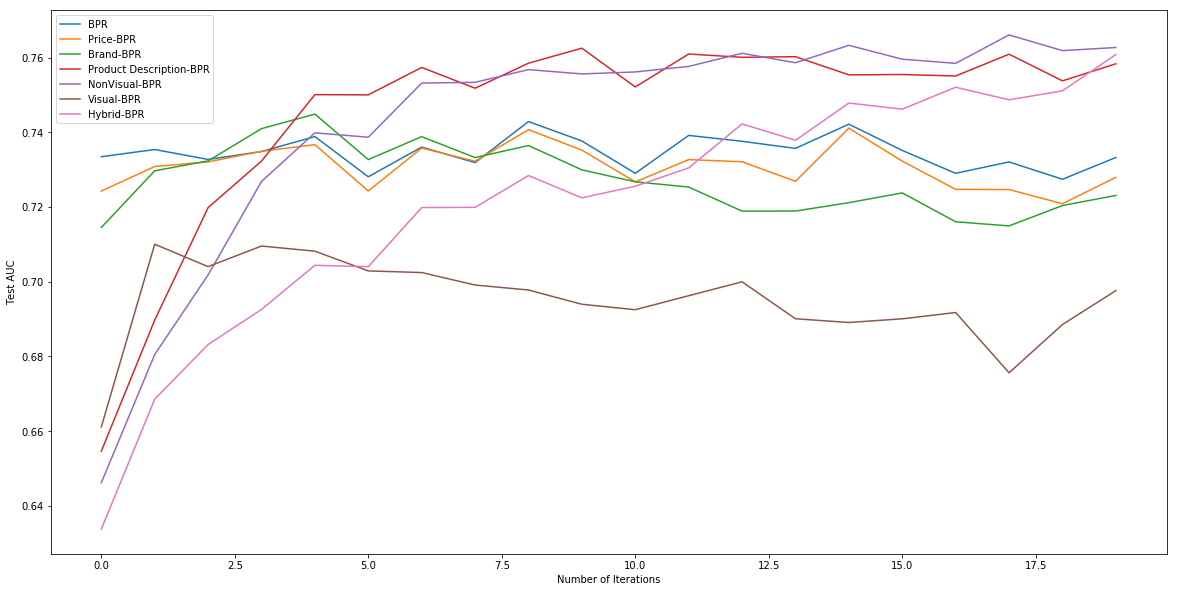

In [26]:
plt.figure(figsize=(20,10))
plt.plot(bpr_auc_test, label = "BPR")
plt.plot(pbpr_auc_test, label = "Price-BPR")
plt.plot(bbpr_auc_test, label = "Brand-BPR")
plt.plot(pdbpr_auc_test, label = "Product Description-BPR")
plt.plot(nvbpr_auc_test, label = "NonVisual-BPR")
plt.plot(vbpr_auc_test, label = "Visual-BPR")
plt.plot(hbpr_auc_test, label = "Hybrid-BPR")
plt.legend()
plt.ylabel("Test AUC")
plt.xlabel("Number of Iterations")

## comparing Cold Start Test AUC vs. number of iterations for different models

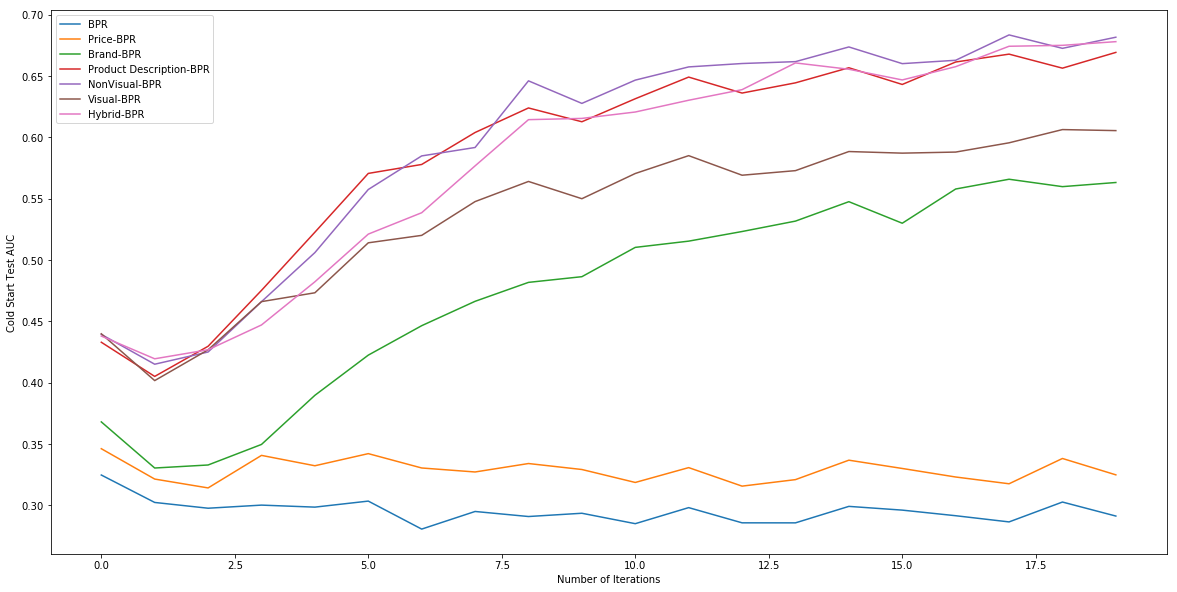

In [27]:
plt.figure(figsize=(20,10))
plt.plot(bpr_auc_test_cold_start, label = "BPR")
plt.plot(pbpr_auc_test_cold_start, label = "Price-BPR")
plt.plot(bbpr_auc_test_cold_start, label = "Brand-BPR")
plt.plot(pdbpr_auc_test_cold_start, label = "Product Description-BPR")
plt.plot(nvbpr_auc_test_cold_start, label = "NonVisual-BPR")
plt.plot(vbpr_auc_test_cold_start, label = "Visual-BPR")
plt.plot(hbpr_auc_test_cold_start, label = "Hybrid-BPR")
plt.legend()
plt.ylabel("Cold Start Test AUC")
plt.xlabel("Number of Iterations")

## Writing the results to a CSV file

In [28]:
import csv
rows = zip(bpr_auc_test, pbpr_auc_test, bbpr_auc_test, pdbpr_auc_test, nvbpr_auc_test, vbpr_auc_test, 
           hbpr_auc_test, bpr_auc_test_cold_start, pbpr_auc_test_cold_start, bbpr_auc_test_cold_start,
          pdbpr_auc_test_cold_start, nvbpr_auc_test_cold_start, vbpr_auc_test_cold_start, hbpr_auc_test_cold_start)

with open("AUC_5core_CellPhones.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerow(["bpr_auc_test", "pbpr_auc_test", "bbpr_auc_test", "pdbpr_auc_test", "nvbpr_auc_test", 
                     "vbpr_auc_test", "hbpr_auc_test", "bpr_auc_test_cold_start", "pbpr_auc_test_cold_start",
                    "bbpr_auc_test_cold_start", "pdbpr_auc_test_cold_start", "nvbpr_auc_test_cold_start",
                    "vbpr_auc_test_cold_start", "hbpr_auc_test_cold_start"])
    for row in rows:
        writer.writerow(row)